In [2]:
import torch
import torch.nn as nn
import pywt
import numpy as np
from dataloader import INRDataset
from model import WaveletCoefficientUpscaler
from utils import *

Using device: cuda


In [5]:
epochs = 10
DATASET_PATH = "D:/Datasets/SuperResolution/"
batch_size = 4
learning_rate = 1e-4

In [6]:

dataset = INRDataset(DATASET_PATH + "dataset/raw_data")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Initialize model, criterion, and optimizer
model = WaveletCoefficientUpscaler().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Training loop
for epoch in range(epochs):
    for i, sample in enumerate(data_loader):
        high_res = sample['high_res'].float().to('cuda')  # High-resolution images
        low_res = sample['low_res'].float().to('cuda')   # Low-resolution images

        batch_size = low_res.size(0)
        low_res_coeffs_list = []
        high_res_coeffs_list = []

        # Apply wavelet transform to each image in the batch
        for b in range(batch_size):
            coeffs = low_res[b].detach().cpu().numpy()  # Shape: [H, W, 3]
            coeffs = wavelet_transform_image(coeffs, wavelet='haar', level=1, GPU=True)  # Wavelet transform
            coeffs = torch.tensor(coeffs, dtype=torch.float32).to('cuda')  # Convert to tensor and move to GPU
            low_res_coeffs_list.append(coeffs.unsqueeze(0))  # Add batch dimension

    
        # Concatenate the transformed coefficients into a single tensor
        low_res_coeffs = torch.cat(low_res_coeffs_list, dim=0)  # Shape: [batch_size, H, W, 12]

        # Pass through the model
        outputs = model(low_res_coeffs)

        

        # Apply wavelet transform to each image in the batch
        for b in range(batch_size):
            coeffs = high_res[b].detach().cpu().numpy()  # Shape: [H, W, 3]
            coeffs = wavelet_transform_image(coeffs, wavelet='haar', level=1, GPU=True)  # Wavelet transform
            coeffs = torch.tensor(coeffs, dtype=torch.float32).to('cuda')  # Convert to tensor and move to GPU
            high_res_coeffs_list.append(coeffs.unsqueeze(0))  # Add batch dimension
        
        # Concatenate the transformed coefficients into a single tensor
        high_res_coeffs = torch.cat(high_res_coeffs_list, dim=0)
        # Change shape to match output
        
        
        # Calculate loss
        loss = criterion(outputs,high_res_coeffs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Percent loss
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")
    



Epoch [1/10], Step [1/214], Loss: 421.1333
Epoch [1/10], Step [11/214], Loss: 171.5118
Epoch [1/10], Step [21/214], Loss: 237.9265
Epoch [1/10], Step [31/214], Loss: 274.8029
Epoch [1/10], Step [41/214], Loss: 261.9363
Epoch [1/10], Step [51/214], Loss: 357.4310
Epoch [1/10], Step [61/214], Loss: 232.8824
Epoch [1/10], Step [71/214], Loss: 203.8135
Epoch [1/10], Step [81/214], Loss: 296.7220
Epoch [1/10], Step [91/214], Loss: 365.8985
Epoch [1/10], Step [101/214], Loss: 165.2550
Epoch [1/10], Step [111/214], Loss: 309.2450
Epoch [1/10], Step [121/214], Loss: 179.5856
Epoch [1/10], Step [131/214], Loss: 164.1134
Epoch [1/10], Step [141/214], Loss: 213.6688
Epoch [1/10], Step [151/214], Loss: 176.3123
Epoch [1/10], Step [161/214], Loss: 81.6871
Epoch [1/10], Step [171/214], Loss: 109.3088
Epoch [1/10], Step [181/214], Loss: 204.8215
Epoch [1/10], Step [191/214], Loss: 96.5911
Epoch [1/10], Step [201/214], Loss: 178.3333
Epoch [1/10], Step [211/214], Loss: 107.8747
Epoch [2/10], Step [1/2

In [14]:
# Save model
torch.save(model.state_dict(), 'wavelet_coeff_upscaler.pth')
print("Model saved")

Model saved


In [2]:
from dataloader import INRDataset
from model import WaveletCoefficientUpscaler

import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from torchmetrics import StructuralSimilarityIndexMeasure
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torchmetrics import StructuralSimilarityIndexMeasure
from utils import *


Using device: cuda


In [3]:
# Load model
model = WaveletCoefficientUpscaler().to('cuda')
model.load_state_dict(torch.load('wavelet_coeff_upscaler.pth'))

DATASET_PATH = "D:/Datasets/SuperResolution/"

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


C:\Users\kunwa\AppData\Local\Temp\ipykernel_17324\45597618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('wavelet_coeff_upscaler.pth')

In [4]:
def visualize_results(lr_image, model_output, hr_image):
    # Convert tensors to PIL images for visualization
    lr_image_pil = to_pil_image(lr_image)
    model_output_pil = to_pil_image(torch.clamp(torch.tensor(model_output, dtype=torch.float32), 0, 1))  # Clamp within [0, 1] for visualization
    hr_image_pil = to_pil_image(hr_image)

    # Create a plot with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(lr_image_pil)
    axes[0].set_title("Low-Resolution Image")
    axes[1].imshow(model_output_pil)
    axes[1].set_title("Model Output (Reconstructed)")
    axes[2].imshow(hr_image_pil)
    axes[2].set_title("High-Resolution Image")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Text(0.5, 1.0, 'High-Resolution Image')

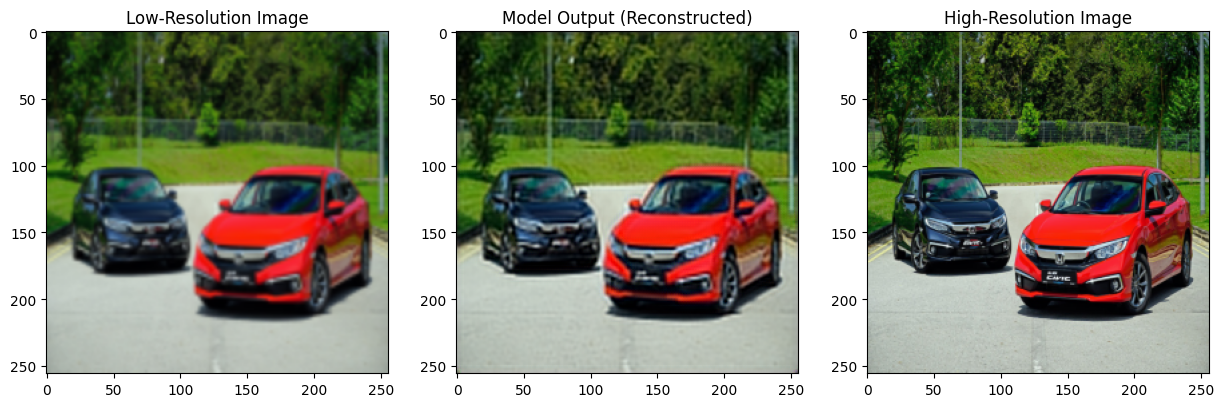

In [5]:
# Test Data 
dataset = INRDataset(DATASET_PATH + "dataset/raw_data")
sample = dataset[0]

lr_image = sample['low_res']

input_image = wavelet_transform_image(sample['low_res'], wavelet='haar', level=1, GPU=True)  # Wavelet transform
input_image = torch.tensor(input_image).float().to(device)  # Low-resolution image
input_image.unsqueeze_(0)


hr_image = sample['high_res']
outputs = model(input_image)


# Example of detaching the model output
outputs = model(input_image)
outputs = outputs.squeeze(0)  # Remove batch dimension for consistency

# Ensure the model output does not have any computation graph associated with it
model_output_np = outputs.cpu().detach().numpy()  
model_output_reconstructed = reconstruct_image_from_coefficients(model_output_np, wavelet='haar', GPU=True)

print(lr_image.shape)
print(hr_image.shape)
print(model_output_reconstructed.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(lr_image)
axes[0].set_title("Low-Resolution Image")
axes[1].imshow(model_output_reconstructed)
axes[1].set_title("Model Output (Reconstructed)")
axes[2].imshow(hr_image)
axes[2].set_title("High-Resolution Image")






In [6]:
# Normalize Images


In [13]:
def calculate_psnr(model_output, hr_image):
    mse = np.mean((model_output - hr_image) ** 2)
    print(f"MSE: {mse:.2f}")
    psnr = 10 * np.log10(255**2 / mse)
    return psnr


In [14]:
# Ensure the model output and high-resolution image are tensors
model_output_tensor = torch.tensor(model_output_reconstructed, dtype=torch.float32).to(device)
hr_image_tensor = torch.tensor(hr_image, dtype=torch.float32).to(device)

# Calculate PSNR
psnr_value = calculate_psnr(model_output_reconstructed, hr_image)
print(psnr_value)

MSE: 50.62
31.087846198583335
